# Concious Self-Organizing Map

The concious self-organizing map of cSOM is a modified version of the Kohonen SOM which include parameters to generate a bais that prevents a single neuron from winning too much and thus generating a more faithful representation of the density distributions of the original parameter space. It works by generating a bais term that gets added to the distance calculation when determining the best matching units.

The parameters that control this will be refered to as beta and gamma. Beta controls how we deal with the winning frequency calculation as is cumulative throughout the training in the bais matrix. Gamma on the other hand is a multiplication factor that influences how much we will add to the distance calculation to deter the same neuron from winning too many times.

Values for beta should generall be 0 < ß << 1
Values for gamma are typically < 10 but I have not fully examined the limitations.

In [1]:
from sciSOM import plot_SOM_gird_neurons, calculate_u_matrix, calculate_density_matrix, display_density_matrix

In [2]:
from sciSOM import plot_SOM_gird_neurons, SOM, affine_transform
import pandas as pd
import numpy as np
import random
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Loading data
As with the Kohonen SOM example we will use 2 datasets. One will be a 4 clusters centered around 4 sets of 2d coordinate with gaussian noise. The second will be the penguins dataset, I data set that has been used to replace the Iris dataset. Similarly to the Iris dataset this one has 3 clusters, one of the being fully separable from the rest but not the other two.

In [3]:
# Lets make a simple dataset which we understand
# I will generate 4 data classes centered at 1,1 1,2 2,1 2,2
# Add some gaussian noise to each of those classes and see
# If the SOM was able to separate them!
n_samples = 2000  # Total number of samples
centers = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])  # Centers of the 4 Gaussian distributions
std_dev = 0.1  # Standard deviation of the Gaussian distributions
n_centers = len(centers)
samples_per_center = n_samples // n_centers

In [4]:
data = []
for center in centers:
    samples = np.random.normal(loc=center, scale=std_dev, size=(samples_per_center, 2))
    data.append(samples)

# Combine all samples into a single array
gaussian_data_4_classes = np.vstack(data)

In [5]:
gaussian_data_4_classes_norm = affine_transform(gaussian_data_4_classes, 0, 1)


### Constructing parameter tables to train the SOM
We will opt to use a decay schedule rather than the decay functions but the setup for both methods will be as bellow

In [6]:
# First we need to define datatypes as the SOM expects a numpy structured 
# array for parameters
dtype = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('beta', 'float'),  # 4-byte float
    ('gamma', 'float')
])

In [7]:
dtypek = np.dtype([
    ('time', 'i8'),  # Unicode string of max length 10
    ('alpha', 'float'),    # 4-byte integer
    ('sigma', 'float'),  # 4-byte float
    ('max_radius', 'i4')
])

In [8]:
parameters = np.zeros(1, dtype=dtype)
parameters_schedule = np.zeros(4, dtype=dtype)

In [9]:
ksom_parm = np.zeros(3, dtype = dtypek)

In [10]:
ksom_parm[0] = (2000, 0.3, 0.3, 3)
ksom_parm[1] = (8000, 0.1, 0.3, 2)
ksom_parm[2] = (20000, 0.05, 0.3, 1)

In [11]:
parameters_schedule = np.zeros(4, dtype=dtype)
parameters_schedule[0] = (2000, 0.5, 0.0001, 5)
parameters_schedule[1] = (8000, 0.3, 0.00008, 1) # 0.00009
parameters_schedule[2] = (20000, 0.05, 0.00005, 0.1) # 0.00008
parameters_schedule[3] = (100000, 0.005, 0.00001, 0.01) # 0.00005

In [12]:
# We can define a save schedule which lets us access the 
# SOM weighcube at different points in the training
# This is particularly useful to aid in diagnosing issues with training
save_schedule = np.array([0, 100, 200, 300,
                         500, 1000, 3000, 5000,
                         10000, 20000, 30_000, 40_000,
                         48_000, 49_000, 49_999])

In [13]:
SOM_grid_dim = 7

# Big current issue
The cSOM learning n_iter needs to be set to a number not module 10. I have 0 clue where this bug is comming from but this needs to be fixed ASAP

In [14]:
# Define the SOM model, details regarding each parameter can be found in the documentation
som_model_simple = SOM(x_dim = SOM_grid_dim, y_dim = SOM_grid_dim, 
                       input_dim = 2, # dimensionality of the data
                       n_iter=40001, # number of training steps
                       learning_parameters=parameters_schedule,
                       som_type = "cSOM", #neighborhood_decay='exponential',
                       decay_type='schedule', mode = "batch", #neighborhood_decay = "none",#"geometric_series"
                       save_weight_cube_history=True,
                       weight_cube_save_states = save_schedule, # When should the SOM save
                       #gamma_off=True # Turns cSOM to a kSOM with radius set to 1
                      )

In [15]:
# Train the SOM model
som_model_simple.train(gaussian_data_4_classes_norm)

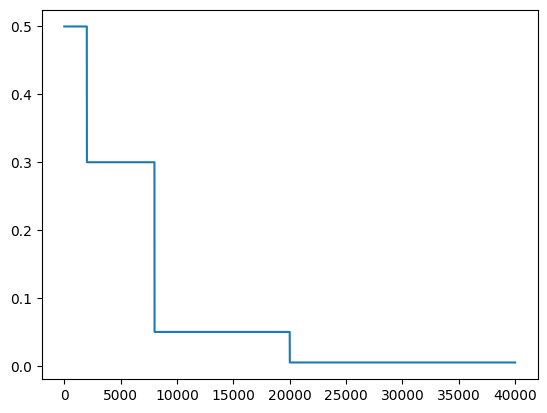

In [16]:
plt.plot(som_model_simple.learning_rate_history)

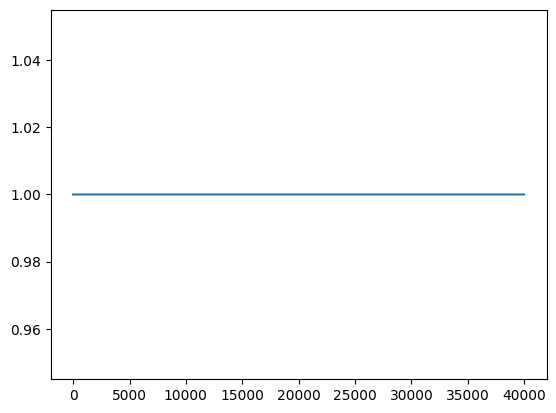

In [17]:
# The radius of the cSOM does not change over time
plt.plot(som_model_simple.learning_radius_history)

In [18]:
def plot_2D_SOM_weights_plus_data(som_dim: int, 
                                  weight_cube: np.ndarray,
                                  save_schedule: np.ndarray = None,
                                 is_single_cube: bool = True) -> None:
    if is_single_cube:
        som_2D_fig(som_dim, weight_cube, save_schedule, )
    
    else:
        #num_weight_cubes, _, _, _ = np.shape(weight_cube)
        for k in np.arange(len(save_schedule)):
            som_2D_fig(som_dim, weight_cube[k], save_schedule, k)


        #plt.savefig(f'figs/SOM_weight_cube_time_step_{save_schedule[k]}.png', dpi = 200)
    

In [19]:
def som_2D_fig(som_dim, weight_cube, save_schedule, k = None):
    N = som_dim
    
    #for k in np.arange(len(som_model_simple.som_save_state)):
    wcube = weight_cube
    # Create the plot
    fig, ax = plt.subplots()

    ax.scatter(gaussian_data_4_classes_norm[:, 0], 
                gaussian_data_4_classes_norm[:, 1], alpha=0.1,
               color = 'red', label = "input data")

    for i in range(N):
        for j in range(N):
            ax.scatter(wcube[i, j, 0], 
                       wcube[i, j, 1], color='blue',
                      alpha = 0.3)

    # Connect adjacent neurons
    for i in range(N):
        for j in range(N):
            # Horizontal connections
            if j < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i, j+1, 0]],
                        [wcube[i, j, 1], 
                         wcube[i, j+1, 1]], color='black')

            # Vertical connections
            if i < N - 1:
                ax.plot([wcube[i, j, 0], 
                         wcube[i+1, j, 0]],
                        [wcube[i, j, 1], 
                         wcube[i+1, j, 1]], color='black')

    # Customize the plot
    if save_schedule is not None:
        ax.set_title(f'SOM Weight Cube Visualization {save_schedule[k]}')
    else:
        ax.set_title(f'SOM Weight Cube Visualization')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.grid(True)
    

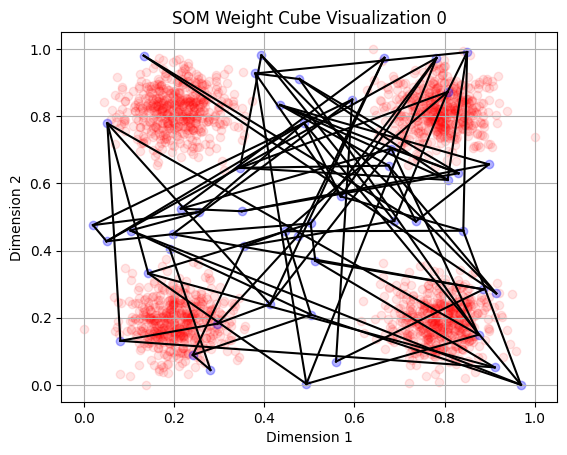

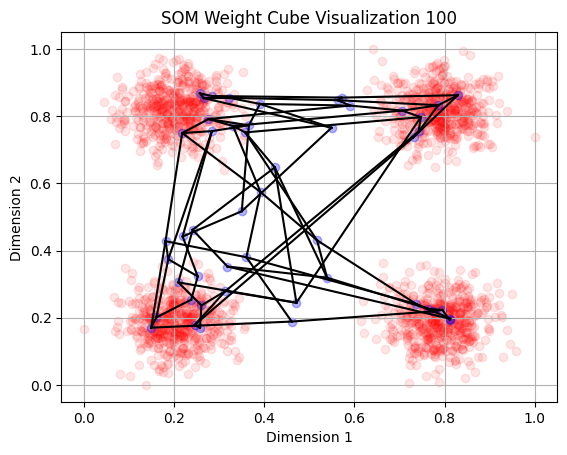

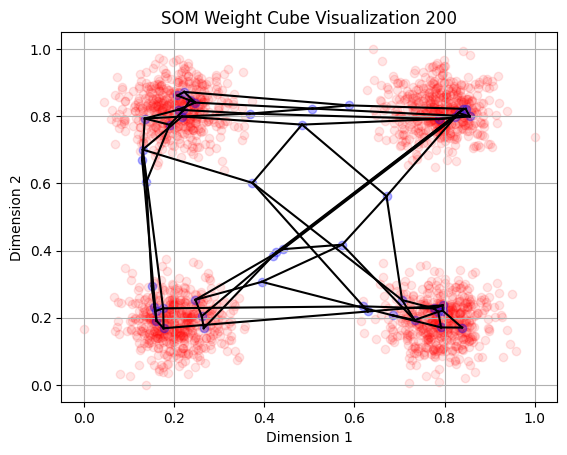

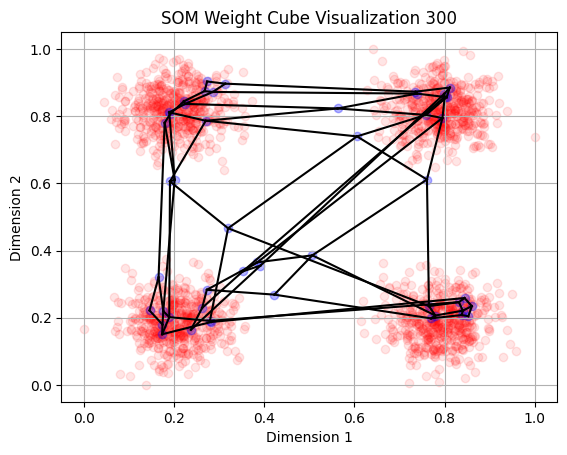

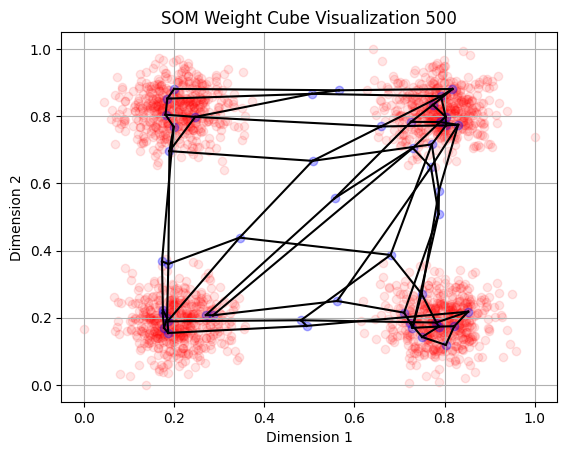

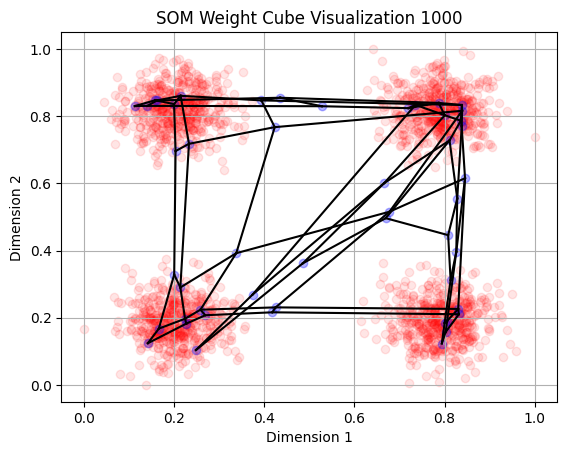

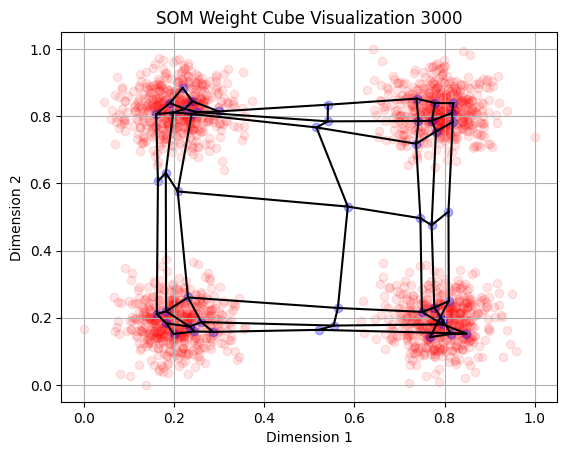

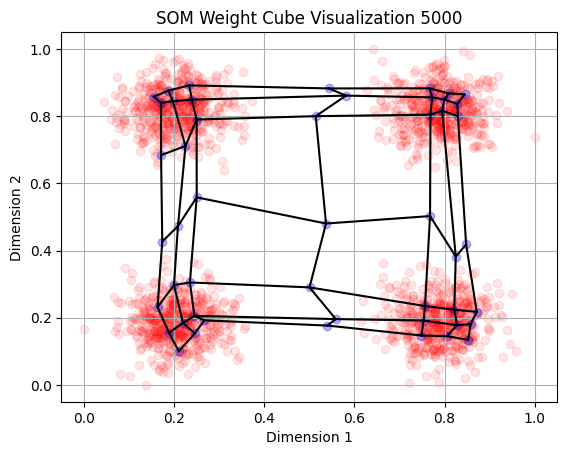

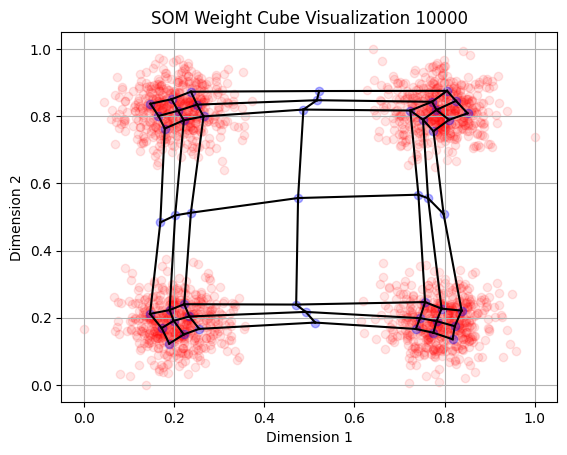

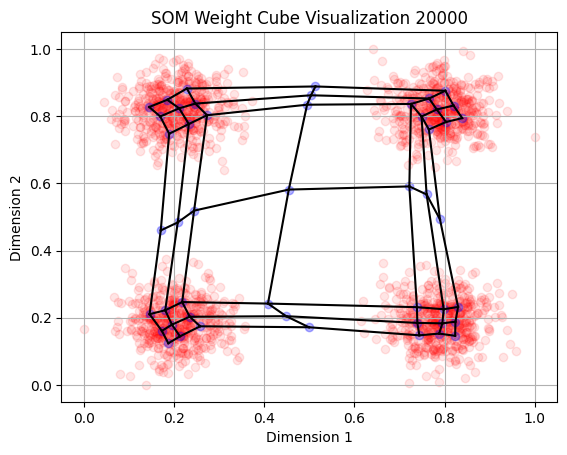

In [20]:
# Plot SOM history to see how it evolved over time!
plot_2D_SOM_weights_plus_data(SOM_grid_dim, som_model_simple.som_save_state,
                              save_schedule[:10],
                             False)

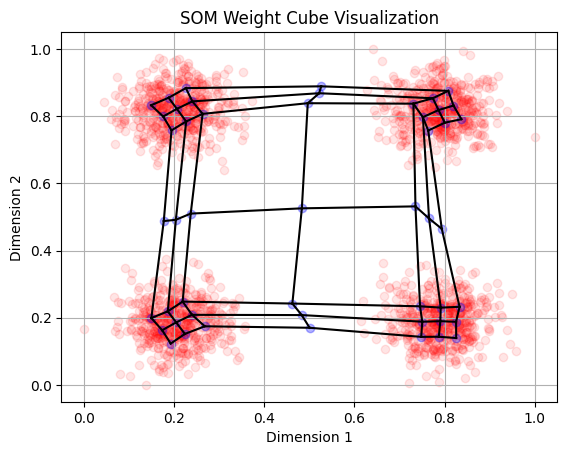

In [21]:
# There seems to be a bit of an issues of twisting SOMs with
# The cSOM we will leave it at that
plot_2D_SOM_weights_plus_data(SOM_grid_dim, som_model_simple.weight_cube,
                             is_single_cube=True)

## cSOM diagnostics

Here I will show some of the diagnostic tools that are built-in to the SOM class. These can be helpful to find issues if you beileve the trained SOM is not adequent

In [22]:
# Shows the number of time each neuron won the BMU
som_model_simple.weight_cube_history

array([[1502.,  947., 1379.,   91., 1363., 1166., 1433.],
       [1028.,  631.,  967.,   65.,  823.,  547., 1018.],
       [1314.,  943., 1090.,   78., 1303., 1011., 1220.],
       [ 125.,   78.,   39.,   33.,   36.,   16.,   44.],
       [1561.,  783., 1302.,   39., 1208.,  863., 1256.],
       [1019.,  635.,  864.,   16.,  951.,  671.,  969.],
       [1358., 1001., 1207.,   57., 1637.,  902., 1412.]])

In [23]:
# Shows the update radius at each step, the cSOM is normally limited
# To only updating the emmidiate neighbors
som_model_simple.save_neighborhood_function[:,:,4]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0.5, 1. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

Text(0, 0.5, 'bais matrix values')

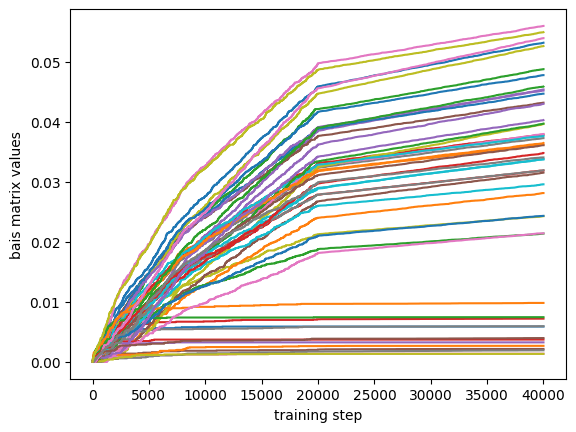

In [24]:
# Shows bais matrix evolution over time, expect values between 0 and 1
# Usually you dont want any neuron getting close to 1
for i in np.arange(SOM_grid_dim**2):
    plt.plot(np.reshape(som_model_simple.bais_matrix_history, 
                        (SOM_grid_dim**2, (som_model_simple.bais_matrix_history).shape[-1]))[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

In [25]:
# This is the value that suppresses neurons from winning too often
supression_mat_vector = som_model_simple.suppresion_matrix_history.reshape(SOM_grid_dim**2,(som_model_simple.suppresion_matrix_history).shape[-1])

Text(0, 0.5, 'Supression matrix values')

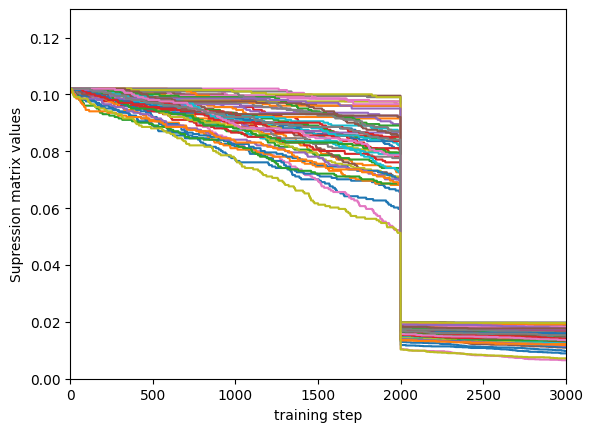

In [26]:
#ax, plt = plt.figure(s)
# Play with parameters until drop isnt as steep
for i in np.arange(SOM_grid_dim**2):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,3000)
plt.ylim(0,0.13)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

Value that is suppressing neurons from winning too much for each neuron.
Typically we want these values to be between 0 and 1, falling bellow
One is acceptable but it can sometimes cause issues which is why we
Keep beta low.

Text(0, 0.5, 'Supression matrix values')

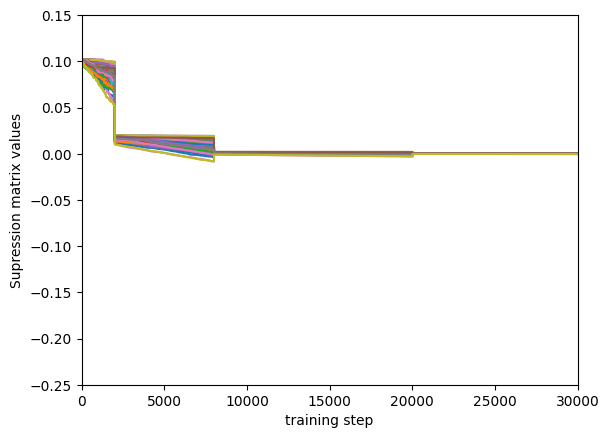

In [27]:

for i in np.arange(SOM_grid_dim**2):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,30000)
plt.ylim(-0.25,0.15)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")

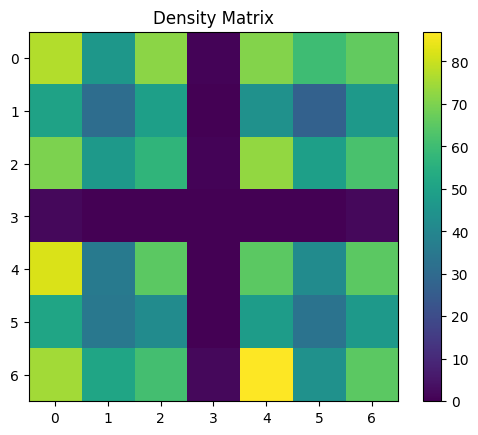

In [28]:
U_MAT = calculate_u_matrix(som_model_simple.weight_cube)
DENS_MAT = calculate_density_matrix(som_model_simple.weight_cube, 
                                    U_MAT, 
                                    gaussian_data_4_classes_norm)
display_density_matrix(DENS_MAT)

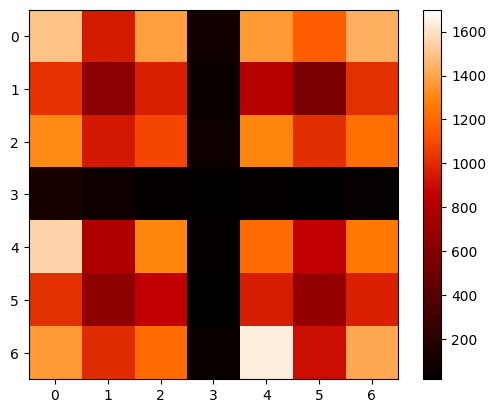

In [29]:
plt.imshow((som_model_simple.weight_cube_history), 
           interpolation="nearest", origin="upper",
           vmax = 1700,
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

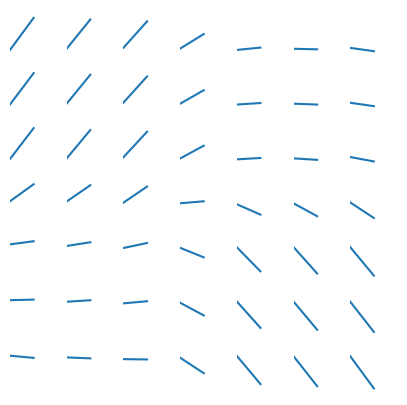

In [30]:
plot_SOM_gird_neurons(som_model_simple.weight_cube)

## Experimentation with parameters examples
From here we will show some of the different parameters I tried to use to show how if affects the cSOM learning. Feel free to ignore these and just treat the as examples but I believe the are informative to watch. Feel free to play with the different parameters and see the different results you get!

Text(0.5, 1.0, 'cSOM, neighborhood radius = 0')

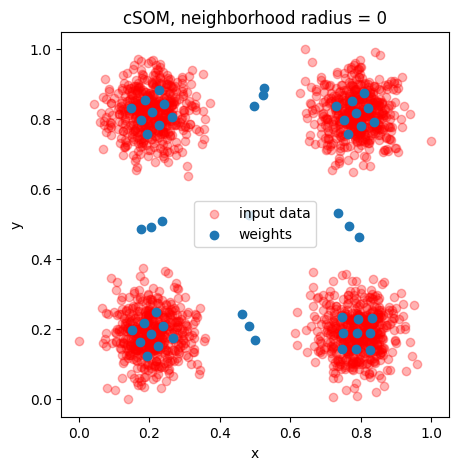

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(gaussian_data_4_classes_norm[:, 0], 
            gaussian_data_4_classes_norm[:, 1], alpha=0.3,
           color = 'red', label = "input data")
plt.scatter(som_model_simple.weight_cube.reshape(7*7,2)[:,0],
           som_model_simple.weight_cube.reshape(7*7,2)[:,1],
           label = "weights")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("cSOM, neighborhood radius = 0") # decay -> none

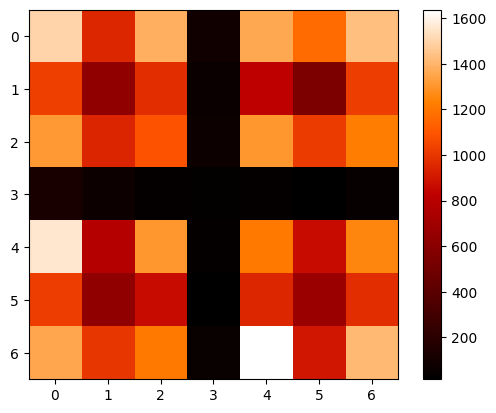

In [32]:
plt.imshow(som_model_simple.weight_cube_history, interpolation="nearest", origin="upper",
          cmap = 'gist_heat')
plt.colorbar()
plt.show()

In [33]:
def convert_to_float(arr):
    # Flatten the array to handle nested objects if any
    flat_arr = arr.ravel()
    
    # Convert all elements to float
    flat_arr = [float(element) for element in flat_arr]
    
    # Reshape back to the original shape
    return np.array(flat_arr).reshape(arr.shape)

## Now lets look at the peguins dataset!

In [34]:
penguins_df = pd.read_csv("../../test_data/penguins.csv")
penguins_df = penguins_df.dropna()

input_data= np.array((penguins_df.to_numpy()[:,2],
                    penguins_df.to_numpy()[:,3],
                    penguins_df.to_numpy()[:,4],
                    penguins_df.to_numpy()[:,5]))

input_data = convert_to_float(input_data)
input_data = np.transpose(input_data)

In [35]:
data_normalized = affine_transform(input_data, 0, 1)

In [36]:
parameters_schedule = np.zeros(4, dtype=dtype)
parameters_schedule[0] = (2000, 0.5, 0.0001, 5)
parameters_schedule[1] = (8000, 0.3, 0.00008, 1) # 0.00009
parameters_schedule[2] = (20000, 0.05, 0.00005, 0.1) # 0.00008
parameters_schedule[3] = (100000, 0.005, 0.00001, 0.01) # 0.00005

In [37]:
som_model_simple = SOM(x_dim = 7, y_dim = 7, input_dim = 4, n_iter=40001,
                   learning_parameters=parameters_schedule, som_type = "cSOM",
                       neighborhood_decay = 'exponential',
                   decay_type='schedule', mode = "online", #neighborhood_decay = "exponential"
                       save_weight_cube_history = True
                   )

In [38]:
som_model_simple.train(data_normalized)

In [39]:
wcube = som_model_simple.weight_cube

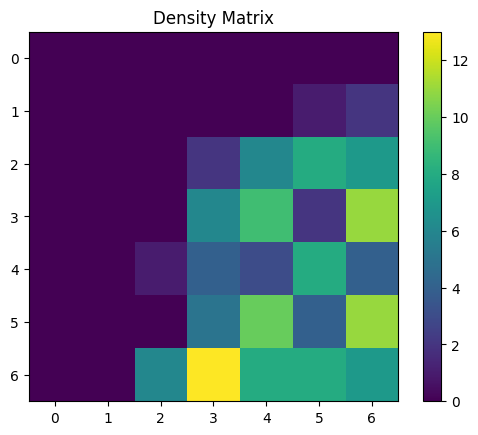

In [40]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[:146])
display_density_matrix(DENS_MAT)

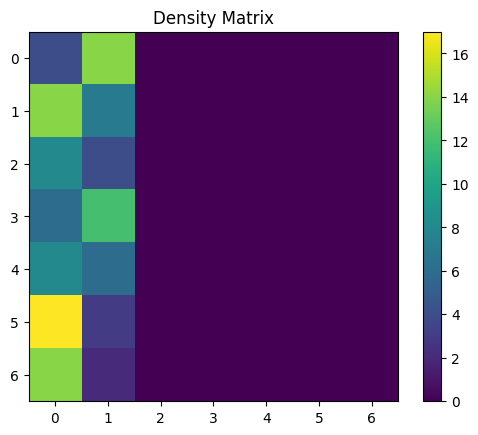

In [41]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146:146+119])
display_density_matrix(DENS_MAT)

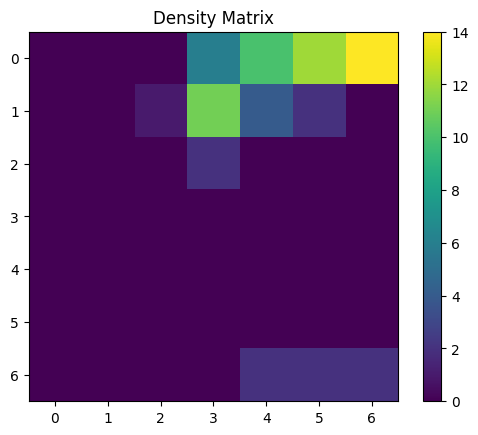

In [42]:
U_MAT = calculate_u_matrix(wcube)
DENS_MAT = calculate_density_matrix(wcube, U_MAT, data_normalized[146+119:])
display_density_matrix(DENS_MAT)

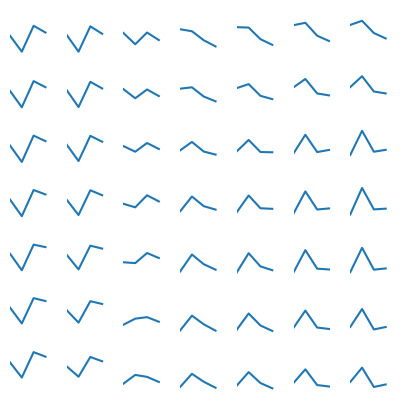

In [43]:
plot_SOM_gird_neurons(wcube)

Text(0, 0.5, 'bais matrix values')

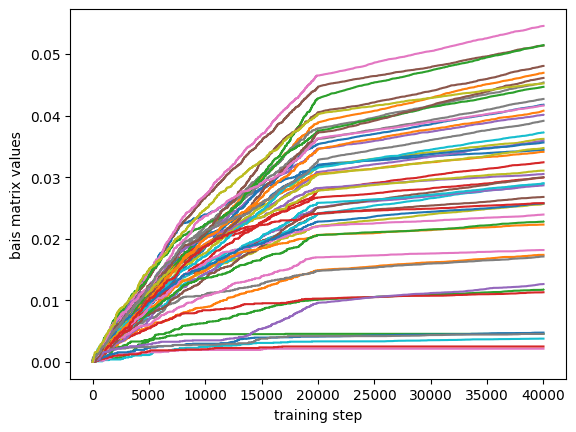

In [44]:
for i in np.arange(SOM_grid_dim**2):
    plt.plot(np.reshape(som_model_simple.bais_matrix_history, 
                        (SOM_grid_dim**2, (som_model_simple.bais_matrix_history).shape[-1]))[i])
    
#plt.xlim(0,1000)
plt.xlabel("training step")
plt.ylabel("bais matrix values")

In [45]:
supression_mat_vector = som_model_simple.suppresion_matrix_history.reshape(SOM_grid_dim**2,(som_model_simple.suppresion_matrix_history).shape[-1])

Text(0, 0.5, 'Supression matrix values')

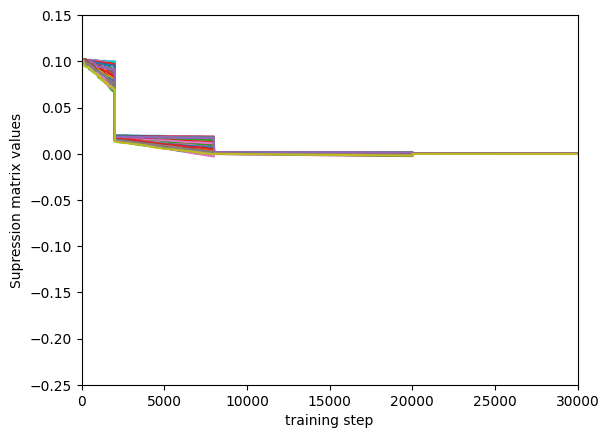

In [46]:

for i in np.arange(SOM_grid_dim**2):
    plt.plot(supression_mat_vector[i])
    
plt.xlim(0,30000)
plt.ylim(-0.25,0.15)
plt.xlabel("training step")
plt.ylabel("Supression matrix values")